In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install torchinfo
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
from torch import nn
import torch
import torchinfo
from  torchvision.ops.deform_conv import DeformConv2d
import PIL
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torchvision
import torch.optim as optim
import timm
# from swin_transformer_pytorch import SwinTransformer
import torchinfo
import sys
from tqdm import tqdm
import time
import copy
import os
import pandas as pd

In [ ]:
transform = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.RandomRotation(45),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                ])
test_transform = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                    ])

device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}

train_dataset_path = '/content/drive/MyDrive/CCPS_research/PlantVillage/grape_leaves_split_aug/train'
valid_dataset_path = '/content/drive/MyDrive/CCPS_research/PlantVillage/grape_leaves_split_aug/val'
test_dataset_path = '/content/drive/MyDrive/CCPS_research/PlantVillage/grape_leaves_split_aug/test'

train_dataset = datasets.ImageFolder(train_dataset_path, transform=transform)
valid_dataset = datasets.ImageFolder(valid_dataset_path, transform=transform)
test_dataset = datasets.ImageFolder(test_dataset_path,transform=test_transform)

train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, **kwargs)
valid_dataloader =  torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True, **kwargs)
test_dataloader =  torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, **kwargs)

CLASSES = train_dataset.classes
train_len = len(train_dataset)
valid_len = len(valid_dataset)
test_len = len(test_dataset)

In [ ]:

dataloaders = {
    "train": train_dataloader,
    "val": valid_dataloader
}
dataset_sizes = {
    "train": train_len,
    "val": valid_len
}

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=3, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input,dim=1)
        # print("logpt is:",logpt)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)
        loss = -1 * (1-pt)**self.gamma * logpt
        # print("loss is :",loss)
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
# # -*- coding: utf-8 -*-
# """
# Created on Thursday Sep 3 9:25:26 2020
# Generate piecewise linear histogram layer
# @author: jpeeples
# """

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import numpy as np
# import pdb

# class HistogramLayer(nn.Module):
#     def __init__(self,in_channels,kernel_size,dim=2,num_bins=4,
#                  stride=1,padding=0,normalize_count=True,normalize_bins = True,
#                  count_include_pad=False,
#                  ceil_mode=False):

#         # inherit nn.module
#         super(HistogramLayer, self).__init__()

#         # define layer properties
#         # histogram bin data
#         self.in_channels = in_channels
#         self.numBins = num_bins
#         self.stride = stride
#         self.kernel_size = kernel_size
#         self.dim = dim
#         self.padding = padding
#         self.normalize_count = normalize_count
#         self.normalize_bins = normalize_bins
#         self.count_include_pad = count_include_pad
#         self.ceil_mode = ceil_mode

#         #For each data type, apply two 1x1 convolutions, 1) to learn bin center (bias)
#         # and 2) to learn bin width
#         # Time series/ signal Data
#         if self.dim == 1:
#             self.bin_centers_conv = nn.Conv1d(self.in_channels,self.numBins*self.in_channels,1,
#                                             groups=self.in_channels,bias=True)
#             self.bin_centers_conv.weight.data.fill_(1)
#             self.bin_centers_conv.weight.requires_grad = False
#             self.bin_widths_conv = nn.Conv1d(self.numBins*self.in_channels,
#                                              self.numBins*self.in_channels,1,
#                                              groups=self.numBins*self.in_channels,
#                                              bias=True)
#             self.bin_widths_conv.bias.data.fill_(1)
#             self.bin_widths_conv.bias.requires_grad = False
#             self.hist_pool = nn.AvgPool1d(self.filt_dim,stride=self.stride,
#                                              padding=self.padding,ceil_mode=self.ceil_mode,
#                                              count_include_pad=self.count_include_pad)
#             self.centers = self.bin_centers_conv.bias
#             self.widths = self.bin_widths_conv.weight

#         # Image Data
#         elif self.dim == 2:
#             self.bin_centers_conv = nn.Conv2d(self.in_channels,self.numBins*self.in_channels,1,
#                                             groups=self.in_channels,bias=True)
#             self.bin_centers_conv.weight.data.fill_(1)
#             self.bin_centers_conv.weight.requires_grad = False
#             self.bin_widths_conv = nn.Conv2d(self.numBins*self.in_channels,
#                                              self.numBins*self.in_channels,1,
#                                              groups=self.numBins*self.in_channels,
#                                              bias=True)
#             self.bin_widths_conv.bias.data.fill_(1)
#             self.bin_widths_conv.bias.requires_grad = False
#             self.hist_pool = nn.AvgPool2d(self.kernel_size,stride=self.stride,
#                                              padding=self.padding,ceil_mode=self.ceil_mode,
#                                              count_include_pad=self.count_include_pad)
#             self.centers = self.bin_centers_conv.bias
#             self.widths = self.bin_widths_conv.weight

#         # Spatial/Temporal or Volumetric Data
#         elif self.dim == 3:
#             self.bin_centers_conv = nn.Conv3d(self.in_channels,self.numBins*self.in_channels,1,
#                                             groups=self.in_channels,bias=True)
#             self.bin_centers_conv.weight.data.fill_(1)
#             self.bin_centers_conv.weight.requires_grad = False
#             self.bin_widths_conv = nn.Conv3d(self.numBins*self.in_channels,
#                                              self.numBins*self.in_channels,1,
#                                              groups=self.numBins*self.in_channels,
#                                              bias=True)
#             self.bin_widths_conv.bias.data.fill_(1)
#             self.bin_widths_conv.bias.requires_grad = False
#             self.hist_pool = nn.AvgPool3d(self.filt_dim,stride=self.stride,
#                                              padding=self.padding,ceil_mode=self.ceil_mode,
#                                              count_include_pad=self.count_include_pad)
#             self.centers = self.bin_centers_conv.bias
#             self.widths = self.bin_widths_conv.weight

#         else:
#             raise RuntimeError('Invalid dimension for histogram layer')

#     def forward(self,xx):
#         ## xx is the input and is a torch.tensor
#         ##each element of output is the frequency for the bin for that window

#         #Pass through first convolution to learn bin centers: |x-center|
#         xx = torch.abs(self.bin_centers_conv(xx))

#         #Pass through second convolution to learn bin widths 1-w*|x-center|
#         xx = self.bin_widths_conv(xx)

#         #Pass through relu
#         xx = F.relu(xx)

#         #Enforce sum to one constraint
#         # Add small positive constant in case sum is zero
#         if(self.normalize_bins):
#             xx = self.constrain_bins(xx)

#         #Get localized histogram output, if normalize, average count
#         if(self.normalize_count):
#             xx = self.hist_pool(xx)
#         else:
#             xx = np.prod(np.asarray(self.hist_pool.kernel_size))*self.hist_pool(xx)

#         return xx


#     def constrain_bins(self,xx):
#         #Enforce sum to one constraint across bins
#         # Time series/ signal Data
#         if self.dim == 1:
#             n,c,l = xx.size()
#             xx_sum = xx.reshape(n, c//self.numBins, self.numBins, l).sum(2) + torch.tensor(10e-6)
#             xx_sum = torch.repeat_interleave(xx_sum,self.numBins,dim=1)
#             xx = xx/xx_sum

#         # Image Data
#         elif self.dim == 2:
#             n,c,h,w = xx.size()
#             xx_sum = xx.reshape(n, c//self.numBins, self.numBins, h, w).sum(2) + torch.tensor(10e-6)
#             xx_sum = torch.repeat_interleave(xx_sum,self.numBins,dim=1)
#             xx = xx/xx_sum

#         # Spatial/Temporal or Volumetric Data
#         elif self.dim == 3:
#             n,c,d,h,w = xx.size()
#             xx_sum = xx.reshape(n, c//self.numBins, self.numBins,d, h, w).sum(2) + torch.tensor(10e-6)
#             xx_sum = torch.repeat_interleave(xx_sum,self.numBins,dim=1)
#             xx = xx/xx_sum

#         else:
#             raise RuntimeError('Invalid dimension for histogram layer')

#         return xx

In [ ]:

class ChannelShuffle(nn.Module):
  def __init__(self,groups):
    super().__init__()
    self.groups = groups

  def forward(self,x):
    """
    Channel shuffle operation from 'ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile Devices,'
    https://arxiv.org/abs/1707.01083.

    Parameters:
    ----------
    x : Tensor
        Input tensor.
    groups : int
        Number of groups.

    Returns
    -------
    Tensor
        Resulted tensor.
    """
    batch, channels, height, width = x.size()
    # assert (channels % groups == 0)
    channels_per_group = channels // self.groups
    x = x.view(batch, self.groups, channels_per_group, height, width)
    # print(x.shape)
    x = torch.transpose(x, 1, 2).contiguous()
    # print(x.shape)
    x = x.view(batch, channels, height, width)
    # print(x.shape)
    return x

In [ ]:
class GSDWR(nn.Module):
  def __init__(self,in_channels,out_channels):
    super().__init__()
    self.groupconv = nn.Conv2d(in_channels = in_channels,out_channels = in_channels,kernel_size = 1,stride=1,groups = 3)
    self.act1 = nn.ReLU()
    self.drop1 = nn.Dropout(0.3)
    self.shuffle = ChannelShuffle(2)

    self.depthwise = nn.Conv2d(in_channels=in_channels,out_channels = in_channels, kernel_size = 2,stride=2, groups = 2)
    self.pointwise = nn.Conv2d(in_channels=in_channels,out_channels = out_channels, kernel_size = 1)

  def forward(self,x):
    inpt = x
    x = self.act1(self.groupconv(x))
    x = self.drop1(x)
    x = self.shuffle(x)
    x = torch.add(x,inpt)
    x = self.depthwise(x)
    x = self.pointwise(x)
    return x


In [ ]:
class DeformableConvBlock(nn.Module):
  def __init__(self,in_channels,out_channels):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels = in_channels, kernel_size=1)
    self.act1 = nn.ReLU()
    self.deformconv = DeformConv2d(in_channels = in_channels, out_channels =in_channels, kernel_size=1,stride = 1)
    # self.deformconv = deform_conv2d(3,3,3,stride=2)
    self.act2 = nn.ReLU()
    self.depthwise = nn.Conv2d(in_channels=in_channels,out_channels = in_channels, kernel_size = 2, stride=2, groups = 2)
    self.pointwise = nn.Conv2d(in_channels=in_channels,out_channels = out_channels, kernel_size = 1)

  def forward(self,x):
    # print(x.shape)
    offset = x
    x = self.act1(self.conv1(x))
    x = self.act2(self.deformconv(x,offset))
    x = self.depthwise(x)
    x = self.pointwise(x)
    return x

In [ ]:
class LinearLayer(nn.Module):
  def __init__(self,input):
    super().__init__()
    self.flat = nn.Flatten()
    self.linear1 = nn.Linear(input, 512)
    self.act1 = nn.ReLU()
    self.drop = nn.Dropout(0.3)
    self.linear2 = nn.Linear(512, 4)

  def forward(self,x):
    x = self.flat(x)
    x = self.act1(self.linear1(x))
    x = self.drop(x)
    x = self.linear2(x)
    return x

In [ ]:
class CNN_model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6,kernel_size = 2,stride=2)
    self.gsdwr1 = GSDWR(6,12)
    self.batchnorm1 = nn.BatchNorm2d(12)
    self.deform1 = DeformableConvBlock(12,24)
    self.batchnorm2 = nn.BatchNorm2d(24)
    self.gsdwr2 = GSDWR(24,48)
    self.batchnorm3 = nn.BatchNorm2d(48)
    self.deform2 = DeformableConvBlock(48,96)
    self.batchnorm4 = nn.BatchNorm2d(96)
    self.linear = LinearLayer(4704)

  def forward(self,x):
    x = self.conv1(x)
    x = self.gsdwr1(x)
    x = self.batchnorm1(x)
    x = self.deform1(x)
    x = self.batchnorm2(x)
    x = self.gsdwr2(x)
    x = self.batchnorm3(x)
    x = self.deform2(x)
    x = self.batchnorm4(x)
    x = self.linear(x)
    return x

model = CNN_model()
torchinfo.summary(model, (32,3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_model                                [32, 4]                   --
├─Conv2d: 1-1                            [32, 6, 112, 112]         78
├─GSDWR: 1-2                             [32, 12, 56, 56]          --
│    └─Conv2d: 2-1                       [32, 6, 112, 112]         18
│    └─ReLU: 2-2                         [32, 6, 112, 112]         --
│    └─Dropout: 2-3                      [32, 6, 112, 112]         --
│    └─ChannelShuffle: 2-4               [32, 6, 112, 112]         --
│    └─Conv2d: 2-5                       [32, 6, 56, 56]           78
│    └─Conv2d: 2-6                       [32, 12, 56, 56]          84
├─BatchNorm2d: 1-3                       [32, 12, 56, 56]          24
├─DeformableConvBlock: 1-4               [32, 24, 28, 28]          --
│    └─Conv2d: 2-7                       [32, 12, 56, 56]          156
│    └─ReLU: 2-8                         [32, 12, 56, 56]          --
│    └─DeformC

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0005)
# criterion = FocalLoss(alpha =class_weights,gamma=2)
criterion = criterion.to(device)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.97)
os.chdir("/content/drive/MyDrive/CCPS_research/logs_grapes")

In [ ]:
# checkpoint = torch.load(f"checkpoints_cnn/model75.pt")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
# print(loss)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, path, train_log, valid_log, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    df_train = pd.DataFrame(columns = ['epoch', 'train_loss', 'train_acc'])
    df_val = pd.DataFrame(columns = ['epoch','val_loss','val_acc'])
    for epoch in range(1,num_epochs+1):
        print(f'Epoch {epoch}/{num_epochs}')
        print("-"*10)


        if not os.path.isdir(path):
          os.mkdir(path)
        # else:
        #   checkpoint = torch.load(f"checkpoints/model{epoch-1}.pt")
        #   model.load_state_dict(checkpoint['model_state_dict'])
        #   optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
          # epoch = checkpoint['epoch']
          # loss = checkpoint['loss']

        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    # print("outputs are: ",outputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    # print("\nEntering loss")
                    loss = criterion(outputs, labels)
                    # print("loss obtained: ",loss)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step() # step at end of epoch

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            # print(type(epoch))
            # print(type(epoch_loss))
            # print(type(epoch_acc))
            if phase=='train':
              # print("Done")
              df_new_row = pd.DataFrame({ 'epoch': [epoch], 'train_loss': [epoch_loss],'train_acc':[epoch_acc.cpu()] })
              # print("done2")
              df_train = pd.concat([df_train, df_new_row])
              df_train.to_csv(f'{path}/{train_log}.csv')
            elif phase=='val':
              df_new_row = pd.DataFrame({ 'epoch': [epoch], 'val_loss': [epoch_loss],'val_acc':[epoch_acc.cpu()] })
              df_val = pd.concat([df_val, df_new_row])
              df_val.to_csv(f'{path}/{valid_log}.csv')
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            ## save torch model for checkpoints
            if epoch%5==0:
              torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': epoch_loss,
              }, f"{path}/model{epoch}.pt")

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()

    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, "grapes_cnn","train_cnn","val_cnn",num_epochs=100)

Epoch 1/100
----------


100%|██████████| 87/87 [05:38<00:00,  3.89s/it]


train Loss: 0.8843 Acc: 0.6147


100%|██████████| 29/29 [02:21<00:00,  4.88s/it]


val Loss: 1.8767 Acc: 0.5156

Epoch 2/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.93it/s]


train Loss: 0.6242 Acc: 0.7387


100%|██████████| 29/29 [00:04<00:00,  6.86it/s]


val Loss: 2.3349 Acc: 0.4585

Epoch 3/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.09it/s]


train Loss: 0.5850 Acc: 0.7667


100%|██████████| 29/29 [00:04<00:00,  7.16it/s]


val Loss: 2.2837 Acc: 0.4736

Epoch 4/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.02it/s]


train Loss: 0.5529 Acc: 0.7692


100%|██████████| 29/29 [00:04<00:00,  6.88it/s]


val Loss: 1.2642 Acc: 0.5653

Epoch 5/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.08it/s]


train Loss: 0.4951 Acc: 0.7847


100%|██████████| 29/29 [00:04<00:00,  6.74it/s]


val Loss: 1.9211 Acc: 0.4693

Epoch 6/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.13it/s]


train Loss: 0.4411 Acc: 0.8249


100%|██████████| 29/29 [00:04<00:00,  5.86it/s]


val Loss: 1.7216 Acc: 0.5965

Epoch 7/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.35it/s]


train Loss: 0.4623 Acc: 0.8196


100%|██████████| 29/29 [00:05<00:00,  5.09it/s]


val Loss: 1.0449 Acc: 0.6365

Epoch 8/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.46it/s]


train Loss: 0.3552 Acc: 0.8569


100%|██████████| 29/29 [00:05<00:00,  5.73it/s]


val Loss: 0.8870 Acc: 0.7055

Epoch 9/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.09it/s]


train Loss: 0.4025 Acc: 0.8462


100%|██████████| 29/29 [00:04<00:00,  6.71it/s]


val Loss: 0.7440 Acc: 0.7562

Epoch 10/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.06it/s]


train Loss: 0.3776 Acc: 0.8616


100%|██████████| 29/29 [00:04<00:00,  7.02it/s]


val Loss: 0.3876 Acc: 0.8479

Epoch 11/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.92it/s]


train Loss: 0.3003 Acc: 0.8900


100%|██████████| 29/29 [00:04<00:00,  6.98it/s]


val Loss: 0.2572 Acc: 0.8900

Epoch 12/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.00it/s]


train Loss: 0.3368 Acc: 0.8799


100%|██████████| 29/29 [00:04<00:00,  7.13it/s]


val Loss: 0.4976 Acc: 0.8414

Epoch 13/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.04it/s]


train Loss: 0.2956 Acc: 0.8875


100%|██████████| 29/29 [00:04<00:00,  6.53it/s]


val Loss: 0.3503 Acc: 0.8738

Epoch 14/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.35it/s]


train Loss: 0.2483 Acc: 0.9094


100%|██████████| 29/29 [00:05<00:00,  5.71it/s]


val Loss: 0.3568 Acc: 0.8673

Epoch 15/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.54it/s]


train Loss: 0.2471 Acc: 0.9091


100%|██████████| 29/29 [00:05<00:00,  5.07it/s]


val Loss: 0.2809 Acc: 0.8770

Epoch 16/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.50it/s]


train Loss: 0.2205 Acc: 0.9145


100%|██████████| 29/29 [00:04<00:00,  5.96it/s]


val Loss: 0.2566 Acc: 0.9105

Epoch 17/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.19it/s]


train Loss: 0.2261 Acc: 0.9245


100%|██████████| 29/29 [00:04<00:00,  6.87it/s]


val Loss: 0.2450 Acc: 0.9083

Epoch 18/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.12it/s]


train Loss: 0.2070 Acc: 0.9234


100%|██████████| 29/29 [00:04<00:00,  7.12it/s]


val Loss: 0.2869 Acc: 0.8943

Epoch 19/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.12it/s]


train Loss: 0.2168 Acc: 0.9180


100%|██████████| 29/29 [00:04<00:00,  7.21it/s]


val Loss: 0.1979 Acc: 0.9320

Epoch 20/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.08it/s]


train Loss: 0.1894 Acc: 0.9303


100%|██████████| 29/29 [00:04<00:00,  7.13it/s]


val Loss: 0.3359 Acc: 0.8857

Epoch 21/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.08it/s]


train Loss: 0.1853 Acc: 0.9313


100%|██████████| 29/29 [00:04<00:00,  6.42it/s]


val Loss: 0.1755 Acc: 0.9342

Epoch 22/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.26it/s]


train Loss: 0.1721 Acc: 0.9357


100%|██████████| 29/29 [00:05<00:00,  5.59it/s]


val Loss: 0.7259 Acc: 0.7907

Epoch 23/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.52it/s]


train Loss: 0.1854 Acc: 0.9299


100%|██████████| 29/29 [00:05<00:00,  5.32it/s]


val Loss: 0.1442 Acc: 0.9493

Epoch 24/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.41it/s]


train Loss: 0.1705 Acc: 0.9382


100%|██████████| 29/29 [00:04<00:00,  6.04it/s]


val Loss: 0.2877 Acc: 0.9018

Epoch 25/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.95it/s]


train Loss: 0.1714 Acc: 0.9389


100%|██████████| 29/29 [00:04<00:00,  6.84it/s]


val Loss: 1.1039 Acc: 0.7044

Epoch 26/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.03it/s]


train Loss: 0.1680 Acc: 0.9375


100%|██████████| 29/29 [00:04<00:00,  7.10it/s]


val Loss: 0.1496 Acc: 0.9450

Epoch 27/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.05it/s]


train Loss: 0.1399 Acc: 0.9493


100%|██████████| 29/29 [00:04<00:00,  7.09it/s]


val Loss: 0.2222 Acc: 0.9148

Epoch 28/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.07it/s]


train Loss: 0.1455 Acc: 0.9454


100%|██████████| 29/29 [00:04<00:00,  6.25it/s]


val Loss: 0.4333 Acc: 0.8662

Epoch 29/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.01it/s]


train Loss: 0.1527 Acc: 0.9504


100%|██████████| 29/29 [00:05<00:00,  5.51it/s]


val Loss: 0.2627 Acc: 0.8997

Epoch 30/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.44it/s]


train Loss: 0.1156 Acc: 0.9558


100%|██████████| 29/29 [00:05<00:00,  5.20it/s]


val Loss: 0.2781 Acc: 0.8997

Epoch 31/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.36it/s]


train Loss: 0.1190 Acc: 0.9590


100%|██████████| 29/29 [00:04<00:00,  6.02it/s]


val Loss: 0.2003 Acc: 0.9266

Epoch 32/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.08it/s]


train Loss: 0.1267 Acc: 0.9565


100%|██████████| 29/29 [00:04<00:00,  6.99it/s]


val Loss: 0.2455 Acc: 0.9223

Epoch 33/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.13it/s]


train Loss: 0.1554 Acc: 0.9457


100%|██████████| 29/29 [00:04<00:00,  7.18it/s]


val Loss: 0.8492 Acc: 0.7767

Epoch 34/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.10it/s]


train Loss: 0.1285 Acc: 0.9526


100%|██████████| 29/29 [00:04<00:00,  6.99it/s]


val Loss: 0.4498 Acc: 0.8630

Epoch 35/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.04it/s]


train Loss: 0.1322 Acc: 0.9543


100%|██████████| 29/29 [00:04<00:00,  7.16it/s]


val Loss: 0.2079 Acc: 0.9191

Epoch 36/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.02it/s]


train Loss: 0.1032 Acc: 0.9630


100%|██████████| 29/29 [00:04<00:00,  6.36it/s]


val Loss: 0.2986 Acc: 0.9148

Epoch 37/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.26it/s]


train Loss: 0.1264 Acc: 0.9590


100%|██████████| 29/29 [00:05<00:00,  5.32it/s]


val Loss: 0.1154 Acc: 0.9601

Epoch 38/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.50it/s]


train Loss: 0.1360 Acc: 0.9500


100%|██████████| 29/29 [00:05<00:00,  5.28it/s]


val Loss: 0.1466 Acc: 0.9450

Epoch 39/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.42it/s]


train Loss: 0.0897 Acc: 0.9659


100%|██████████| 29/29 [00:04<00:00,  6.09it/s]


val Loss: 0.0874 Acc: 0.9655

Epoch 40/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.07it/s]


train Loss: 0.0791 Acc: 0.9741


100%|██████████| 29/29 [00:04<00:00,  7.03it/s]


val Loss: 0.1937 Acc: 0.9407

Epoch 41/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.89it/s]


train Loss: 0.1102 Acc: 0.9561


100%|██████████| 29/29 [00:04<00:00,  6.94it/s]


val Loss: 0.1286 Acc: 0.9461

Epoch 42/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.04it/s]


train Loss: 0.0920 Acc: 0.9687


100%|██████████| 29/29 [00:04<00:00,  6.97it/s]


val Loss: 0.1517 Acc: 0.9461

Epoch 43/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.09it/s]


train Loss: 0.0945 Acc: 0.9687


100%|██████████| 29/29 [00:04<00:00,  7.02it/s]


val Loss: 0.1784 Acc: 0.9439

Epoch 44/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.08it/s]


train Loss: 0.1236 Acc: 0.9601


100%|██████████| 29/29 [00:04<00:00,  5.98it/s]


val Loss: 0.1954 Acc: 0.9266

Epoch 45/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.46it/s]


train Loss: 0.0886 Acc: 0.9669


100%|██████████| 29/29 [00:05<00:00,  5.25it/s]


val Loss: 0.0852 Acc: 0.9655

Epoch 46/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.41it/s]


train Loss: 0.1042 Acc: 0.9633


100%|██████████| 29/29 [00:05<00:00,  5.64it/s]


val Loss: 0.2807 Acc: 0.9288

Epoch 47/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.31it/s]


train Loss: 0.0935 Acc: 0.9655


100%|██████████| 29/29 [00:04<00:00,  6.33it/s]


val Loss: 0.0809 Acc: 0.9709

Epoch 48/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.05it/s]


train Loss: 0.0870 Acc: 0.9659


100%|██████████| 29/29 [00:04<00:00,  6.95it/s]


val Loss: 0.1069 Acc: 0.9612

Epoch 49/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.87it/s]


train Loss: 0.0984 Acc: 0.9669


100%|██████████| 29/29 [00:04<00:00,  6.95it/s]


val Loss: 0.1962 Acc: 0.9331

Epoch 50/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.98it/s]


train Loss: 0.1198 Acc: 0.9565


100%|██████████| 29/29 [00:04<00:00,  7.01it/s]


val Loss: 0.2978 Acc: 0.8932

Epoch 51/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.94it/s]


train Loss: 0.1104 Acc: 0.9615


100%|██████████| 29/29 [00:04<00:00,  6.49it/s]


val Loss: 0.1159 Acc: 0.9655

Epoch 52/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.12it/s]


train Loss: 0.0973 Acc: 0.9680


100%|██████████| 29/29 [00:05<00:00,  5.47it/s]


val Loss: 0.4347 Acc: 0.8662

Epoch 53/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.23it/s]


train Loss: 0.0699 Acc: 0.9763


100%|██████████| 29/29 [00:05<00:00,  5.28it/s]


val Loss: 0.1717 Acc: 0.9417

Epoch 54/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.19it/s]


train Loss: 0.0778 Acc: 0.9705


100%|██████████| 29/29 [00:07<00:00,  3.92it/s]


val Loss: 0.3629 Acc: 0.8835

Epoch 55/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.82it/s]


train Loss: 0.0756 Acc: 0.9774


100%|██████████| 29/29 [00:04<00:00,  6.52it/s]


val Loss: 0.1026 Acc: 0.9633

Epoch 56/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.93it/s]


train Loss: 0.0744 Acc: 0.9738


100%|██████████| 29/29 [00:04<00:00,  6.83it/s]


val Loss: 0.3215 Acc: 0.8986

Epoch 57/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.01it/s]


train Loss: 0.0890 Acc: 0.9633


100%|██████████| 29/29 [00:05<00:00,  5.78it/s]


val Loss: 0.1107 Acc: 0.9622

Epoch 58/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.86it/s]


train Loss: 0.0858 Acc: 0.9741


100%|██████████| 29/29 [00:05<00:00,  5.27it/s]


val Loss: 0.2734 Acc: 0.9223

Epoch 59/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.54it/s]


train Loss: 0.0852 Acc: 0.9691


100%|██████████| 29/29 [00:04<00:00,  5.96it/s]


val Loss: 0.3086 Acc: 0.8910

Epoch 60/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.17it/s]


train Loss: 0.0867 Acc: 0.9684


100%|██████████| 29/29 [00:04<00:00,  6.82it/s]


val Loss: 0.1341 Acc: 0.9504

Epoch 61/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.04it/s]


train Loss: 0.0561 Acc: 0.9802


100%|██████████| 29/29 [00:04<00:00,  7.04it/s]


val Loss: 0.0709 Acc: 0.9730

Epoch 62/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.03it/s]


train Loss: 0.0745 Acc: 0.9745


100%|██████████| 29/29 [00:04<00:00,  7.09it/s]


val Loss: 0.3802 Acc: 0.9029

Epoch 63/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.07it/s]


train Loss: 0.0775 Acc: 0.9720


100%|██████████| 29/29 [00:04<00:00,  7.12it/s]


val Loss: 0.0922 Acc: 0.9622

Epoch 64/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.99it/s]


train Loss: 0.0816 Acc: 0.9709


100%|██████████| 29/29 [00:04<00:00,  6.10it/s]


val Loss: 0.0681 Acc: 0.9763

Epoch 65/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.28it/s]


train Loss: 0.0832 Acc: 0.9705


100%|██████████| 29/29 [00:05<00:00,  5.08it/s]


val Loss: 0.1192 Acc: 0.9558

Epoch 66/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.34it/s]


train Loss: 0.0679 Acc: 0.9734


100%|██████████| 29/29 [00:05<00:00,  5.63it/s]


val Loss: 0.1165 Acc: 0.9590

Epoch 67/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.18it/s]


train Loss: 0.0789 Acc: 0.9759


100%|██████████| 29/29 [00:04<00:00,  6.48it/s]


val Loss: 0.0729 Acc: 0.9709

Epoch 68/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.99it/s]


train Loss: 0.0876 Acc: 0.9669


100%|██████████| 29/29 [00:04<00:00,  6.92it/s]


val Loss: 0.0914 Acc: 0.9741

Epoch 69/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.81it/s]


train Loss: 0.0753 Acc: 0.9734


100%|██████████| 29/29 [00:04<00:00,  6.79it/s]


val Loss: 0.0626 Acc: 0.9849

Epoch 70/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.93it/s]


train Loss: 0.0666 Acc: 0.9774


100%|██████████| 29/29 [00:04<00:00,  7.00it/s]


val Loss: 0.1621 Acc: 0.9558

Epoch 71/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.84it/s]


train Loss: 0.0681 Acc: 0.9781


100%|██████████| 29/29 [00:04<00:00,  5.93it/s]


val Loss: 0.3011 Acc: 0.8943

Epoch 72/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.24it/s]


train Loss: 0.0507 Acc: 0.9842


100%|██████████| 29/29 [00:05<00:00,  5.15it/s]


val Loss: 0.2068 Acc: 0.9385

Epoch 73/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.26it/s]


train Loss: 0.0777 Acc: 0.9720


100%|██████████| 29/29 [00:05<00:00,  5.71it/s]


val Loss: 0.1578 Acc: 0.9504

Epoch 74/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.93it/s]


train Loss: 0.0731 Acc: 0.9763


100%|██████████| 29/29 [00:04<00:00,  6.83it/s]


val Loss: 0.2608 Acc: 0.9083

Epoch 75/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.94it/s]


train Loss: 0.0607 Acc: 0.9792


100%|██████████| 29/29 [00:04<00:00,  6.93it/s]


val Loss: 0.1595 Acc: 0.9428

Epoch 76/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.91it/s]


train Loss: 0.0810 Acc: 0.9705


100%|██████████| 29/29 [00:04<00:00,  6.97it/s]


val Loss: 0.0871 Acc: 0.9687

Epoch 77/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.90it/s]


train Loss: 0.0549 Acc: 0.9802


100%|██████████| 29/29 [00:04<00:00,  6.42it/s]


val Loss: 0.3367 Acc: 0.8824

Epoch 78/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.03it/s]


train Loss: 0.0635 Acc: 0.9788


100%|██████████| 29/29 [00:05<00:00,  5.78it/s]


val Loss: 0.0646 Acc: 0.9720

Epoch 79/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.22it/s]


train Loss: 0.0541 Acc: 0.9817


100%|██████████| 29/29 [00:05<00:00,  4.89it/s]


val Loss: 0.1961 Acc: 0.9439

Epoch 80/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.27it/s]


train Loss: 0.0663 Acc: 0.9759


100%|██████████| 29/29 [00:04<00:00,  5.90it/s]


val Loss: 0.0751 Acc: 0.9698

Epoch 81/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.85it/s]


train Loss: 0.0449 Acc: 0.9835


100%|██████████| 29/29 [00:04<00:00,  6.86it/s]


val Loss: 0.0633 Acc: 0.9730

Epoch 82/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.99it/s]


train Loss: 0.0669 Acc: 0.9752


100%|██████████| 29/29 [00:04<00:00,  6.78it/s]


val Loss: 0.4063 Acc: 0.8759

Epoch 83/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.84it/s]


train Loss: 0.0954 Acc: 0.9676


100%|██████████| 29/29 [00:04<00:00,  6.78it/s]


val Loss: 0.5099 Acc: 0.8630

Epoch 84/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.91it/s]


train Loss: 0.0549 Acc: 0.9799


100%|██████████| 29/29 [00:04<00:00,  6.26it/s]


val Loss: 0.2064 Acc: 0.9191

Epoch 85/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.15it/s]


train Loss: 0.0556 Acc: 0.9766


100%|██████████| 29/29 [00:05<00:00,  5.45it/s]


val Loss: 0.0796 Acc: 0.9773

Epoch 86/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.32it/s]


train Loss: 0.0593 Acc: 0.9781


100%|██████████| 29/29 [00:05<00:00,  5.16it/s]


val Loss: 0.3522 Acc: 0.8878

Epoch 87/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.33it/s]


train Loss: 0.0660 Acc: 0.9770


100%|██████████| 29/29 [00:04<00:00,  5.92it/s]


val Loss: 0.1039 Acc: 0.9644

Epoch 88/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.95it/s]


train Loss: 0.0572 Acc: 0.9820


100%|██████████| 29/29 [00:04<00:00,  6.95it/s]


val Loss: 0.0475 Acc: 0.9849

Epoch 89/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.97it/s]


train Loss: 0.0448 Acc: 0.9831


100%|██████████| 29/29 [00:04<00:00,  6.91it/s]


val Loss: 0.1967 Acc: 0.9277

Epoch 90/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.86it/s]


train Loss: 0.0682 Acc: 0.9795


100%|██████████| 29/29 [00:04<00:00,  6.85it/s]


val Loss: 0.0784 Acc: 0.9709

Epoch 91/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.89it/s]


train Loss: 0.0619 Acc: 0.9777


100%|██████████| 29/29 [00:04<00:00,  6.65it/s]


val Loss: 0.1264 Acc: 0.9493

Epoch 92/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.08it/s]


train Loss: 0.0446 Acc: 0.9824


100%|██████████| 29/29 [00:05<00:00,  5.64it/s]


val Loss: 0.1042 Acc: 0.9687

Epoch 93/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.31it/s]


train Loss: 0.0542 Acc: 0.9788


100%|██████████| 29/29 [00:05<00:00,  5.14it/s]


val Loss: 0.1260 Acc: 0.9579

Epoch 94/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.31it/s]


train Loss: 0.0673 Acc: 0.9788


100%|██████████| 29/29 [00:04<00:00,  5.86it/s]


val Loss: 0.1281 Acc: 0.9525

Epoch 95/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.99it/s]


train Loss: 0.0802 Acc: 0.9734


100%|██████████| 29/29 [00:04<00:00,  7.01it/s]


val Loss: 0.4310 Acc: 0.8533

Epoch 96/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.91it/s]


train Loss: 0.0420 Acc: 0.9827


100%|██████████| 29/29 [00:04<00:00,  7.05it/s]


val Loss: 0.0949 Acc: 0.9666

Epoch 97/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.95it/s]


train Loss: 0.0605 Acc: 0.9799


100%|██████████| 29/29 [00:04<00:00,  6.97it/s]


val Loss: 0.0987 Acc: 0.9676

Epoch 98/100
----------


100%|██████████| 87/87 [00:14<00:00,  5.98it/s]


train Loss: 0.0459 Acc: 0.9835


100%|██████████| 29/29 [00:04<00:00,  6.57it/s]


val Loss: 0.1067 Acc: 0.9655

Epoch 99/100
----------


100%|██████████| 87/87 [00:14<00:00,  6.11it/s]


train Loss: 0.0359 Acc: 0.9885


100%|██████████| 29/29 [00:05<00:00,  5.71it/s]


val Loss: 0.1182 Acc: 0.9644

Epoch 100/100
----------


100%|██████████| 87/87 [00:13<00:00,  6.46it/s]


train Loss: 0.0713 Acc: 0.9748


100%|██████████| 29/29 [00:05<00:00,  4.95it/s]


val Loss: 0.8962 Acc: 0.7907

Training complete in 39m 24s
Best Val Acc: 0.9849


In [ ]:
checkpoint = torch.load(f"grapes_cnn/model85.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(loss)

0.07956449948090501


In [ ]:
predictions = []
label = []
for inputs, labels in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()

    with torch.set_grad_enabled(True): # no autograd makes validation go faster
        outputs = model(inputs)
        # print("outputs are: ",outputs)
        _, preds = torch.max(outputs, 1) # used for accuracy
        for i in preds:
          predictions.append(i)
        for i in labels:
          label.append(i)

  0%|          | 0/30 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 30/30 [03:07<00:00,  4.34s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 30/30 [03:07<00:00,  6.25s/it]


In [ ]:
predictions_cpu = [int(i.cpu().numpy()) for i in predictions]
label_cpu = [int(i.cpu().numpy()) for i in label]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label_cpu, predictions_cpu,zero_division = 0,target_names = CLASSES, digits=4))
# sum(p.numel() for p in x.parameters() if p.requires_grad)

                                            precision    recall  f1-score   support

                         Grape___Black_rot     0.9353    0.9195    0.9274       236
              Grape___Esca_(Black_Measles)     0.9356    0.9928    0.9634       278
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)     0.9953    0.9815    0.9883       216
                           Grape___healthy     1.0000    0.9500    0.9744       200

                                  accuracy                         0.9624       930
                                 macro avg     0.9666    0.9609    0.9634       930
                              weighted avg     0.9632    0.9624    0.9624       930



In [ ]:
CLASSES

['Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy']

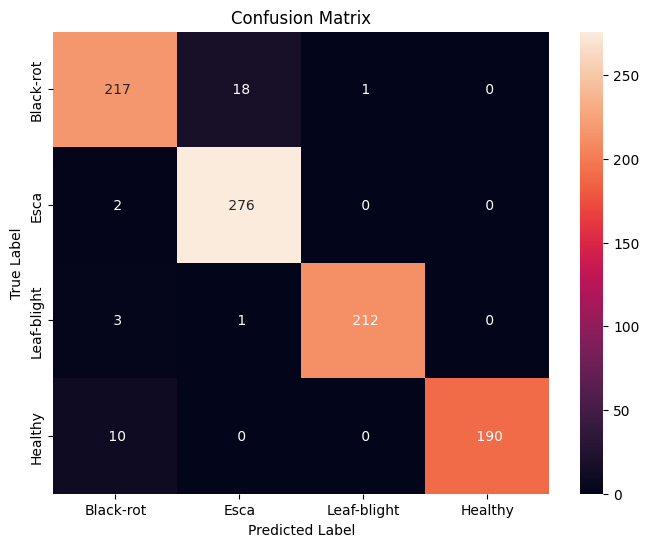

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cf_matrix = confusion_matrix(label_cpu, predictions_cpu)

labels = ['Black-rot','Esca','Leaf-blight','Healthy']
# cm_str = np.asarray(cf_matrix, dtype=str)
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot = True, fmt = ' ',xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.savefig('/content/confusion_matrix_cnn.pdf', bbox_inches='tight')
plt.savefig('/content/confusion_matrix_cnn.png', bbox_inches='tight')

plt.show()

<Figure size 640x480 with 0 Axes>